# Load GT & Vis

In [1]:
import xml.etree.ElementTree as ET
from tqdm import tqdm
import os
import natsort
import cv2
import matplotlib.pyplot as plt
import json
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
# COUNTRY_NAMES = ['India', 'Czech', 'Japan',
#                'China_MotorBike', 'United_States']

In [3]:
country = "United_States"

IMAGE_DIR = "/SSD/IEEE/data/"+country+"/train/images/"
ANN_DIR = "/SSD/IEEE/data/"+country+"/train/annotations/xmls/"

SAVE_AIHUB_form_DIR = "/SSD/IEEE/data/"+country+"/train/annotations/aihub_json"
if not os.path.exists(SAVE_AIHUB_form_DIR): 
    os.makedirs(SAVE_AIHUB_form_DIR)

target_cls = ['D00','D10','D20','D40']


In [4]:
def get_image_file_names(IMAGE_DIR):
    
    file_format = ['jpg','png','JPG','PNG']
    
    file_names = os.listdir(IMAGE_DIR)
    image_file_names = []
    for file_name in tqdm(file_names):
        if file_name.split('.')[-1] in file_format:
            image_file_names.append(file_name)
   
    return natsort.natsorted(image_file_names)

def get_ann_file_names(ANN_DIR):
    
    file_format = ['xml','json']
    
    file_names = os.listdir(ANN_DIR)
    ann_file_names = []
    for file_name in tqdm(file_names):
        if file_name.split('.')[-1] in file_format:
            ann_file_names.append(file_name)
   
    return natsort.natsorted(ann_file_names)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4805/4805 [00:00<00:00, 611847.07it/s]


640 640


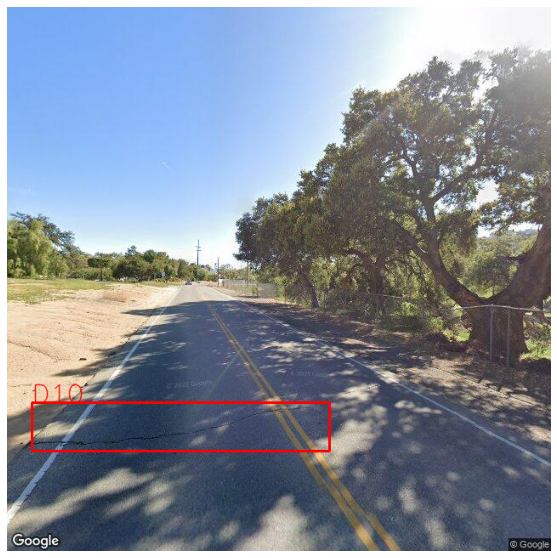

In [5]:
ann_file_names = get_ann_file_names(ANN_DIR)


start_index = 100
count = 0
for idx,ann_file in enumerate(ann_file_names):
    if idx>start_index and count<1:
        count+=1
        tree = ET.parse(os.path.join(ANN_DIR,ann_file))
        root = tree.getroot()

        if root.findtext('segmented') == '1':
            print('Warning')
            break

        filename = root.findtext('filename')
        img_w = root.find('size').findtext('width')
        img_h = root.find('size').findtext('height')
        objs = root.findall('object')

        # load image
        image_path = os.path.join(IMAGE_DIR, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        gt = []
        for obj in objs:
            temp = {}

            cls_name = obj.findtext('name')
            temp['cls_name'] = cls_name

            bbox = obj.find('bndbox')
            x1 = int(float(bbox.findtext('xmin')))
            y1 = int(float(bbox.findtext('ymin')))
            x2 = int(float(bbox.findtext('xmax')))
            y2 = int(float(bbox.findtext('ymax')))
            temp['bbox'] = [x1,y1,x2,y2]

            if x2 <= x1 or y2 <= y1:
                print(f"Box size error !: {x1, y1, x2, y2}")
                break
            elif cls_name not in target_cls:
                print(f"Delete class: {cls_name}")
                break
            else:
                gt.append(temp)

                # Draw bbox
                image = cv2.rectangle(image, (x1,y1), (x2,y2), (255,0,0), 2)
                cv2.putText(image, cls_name, (x1,y1), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        # print(filename)
        print(img_w, img_h)
        # print(gt)

        plt.figure(figsize=(14,10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# to AIHUB form

In [6]:
ann_file_names = get_ann_file_names(ANN_DIR)

for idx,ann_file in enumerate(ann_file_names):
    
    tree = ET.parse(os.path.join(ANN_DIR,ann_file))
    root = tree.getroot()
    
    filename = root.findtext('filename')
    img_w = int(root.find('size').findtext('width'))
    img_h = int(root.find('size').findtext('height'))
    objs = root.findall('object')
    
    # Declare saved json form
    save_json = {}
    image_dict = {}
    image_dict['filename'] = filename
    image_dict['resolution'] = [img_w, img_h]
    
    
    annotation_dict = []
    for obj in objs:
        annotation_dict_temp = {}

        cls_name = obj.findtext('name')
        
        bbox = obj.find('bndbox')
        x1 = int(float(bbox.findtext('xmin')))
        y1 = int(float(bbox.findtext('ymin')))
        x2 = int(float(bbox.findtext('xmax')))
        y2 = int(float(bbox.findtext('ymax')))
        if x2 <= x1 or y2 <= y1:
            print(f"Box size error !: {x1, y1, x2, y2}")
            pass
        elif cls_name not in target_cls:
            # print(f"Delete class: {cls_name}")
            pass
        else:
            annotation_dict_temp['box'] = [x1,y1,x2,y2]
            annotation_dict_temp['class'] = cls_name
            annotation_dict.append(annotation_dict_temp)
            
    save_json['image'] = image_dict
    save_json['annotations'] = annotation_dict
    
    save_path = os.path.join(SAVE_AIHUB_form_DIR, filename.split('.')[0]+'.json')
    with open(save_path, 'w', encoding='utf-8') as make_file:
        json.dump(save_json, make_file, indent="\t")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4805/4805 [00:00<00:00, 664609.90it/s]


# Split base on ratio

In [7]:
# load json file
annotations_path = SAVE_AIHUB_form_DIR # Train included test file

label_file_names = get_ann_file_names(annotations_path)

len(label_file_names)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4805/4805 [00:00<00:00, 544133.88it/s]


4805

In [8]:
file_list = label_file_names
path = annotations_path

category_list=[]
for idx,file_name in tqdm(enumerate(file_list)):
    with open(os.path.join(annotations_path,file_name), 'r') as f:
        json_data = json.load(f)

    # categories
    for idy,instance in enumerate(json_data["annotations"]):
        if instance["class"] in category_list:
            pass
        else:
            category_list.append(instance["class"])
    category_list=natsort.natsorted(category_list)
    category_dic_count = dict.fromkeys(category_list, 0)
    category_dic_filename = dict.fromkeys(category_list)
    
    for key in category_dic_filename.keys():
        category_dic_filename[key]=[]

4805it [00:04, 1149.28it/s]


In [9]:
print(category_list)
print(category_dic_count)

['D00', 'D10', 'D20', 'D40']
{'D00': 0, 'D10': 0, 'D20': 0, 'D40': 0}


### Count & Dist

In [10]:
file_list = natsort.natsorted(file_list)

ban_list = []
for idx,file_name in tqdm(enumerate(file_list)):

    with open(os.path.join(path,file_name), 'r') as f:
        json_data = json.load(f)

    class_id_list = []
    # categories
    for idy,instance in enumerate(json_data["annotations"]):
        class_id_list.append(instance["class"])


    # print(class_id_list)

    count_items = Counter(class_id_list)

    # print(count_items)
    
    try:
        class_id = count_items.most_common(n=1)[0][0]
        category_dic_count[class_id]+=1
        category_dic_filename[class_id].append(file_name)
    except:
        ban_list.append(file_name)

4805it [00:02, 1948.85it/s]


In [11]:
train = [] 
test = [] 

for key in category_dic_count.keys():

    if (category_dic_count[key]):
        temp=category_dic_filename[key]

        train_temp, test_temp = train_test_split(temp, test_size=0.1)

        train.extend(train_temp)
        test.extend(test_temp)

In [12]:
category_dic_total_count = dict.fromkeys(category_list, 0)

for idx,file_name in tqdm(enumerate(file_list)):
    with open(os.path.join(path,file_name), 'r') as f:
        json_data = json.load(f)
    
    # categories
    for idy,instance in enumerate(json_data["annotations"]):
        category_dic_total_count[instance["class"]]+=1
        
category_dic_total_count

4805it [00:02, 2012.58it/s]


{'D00': 6750, 'D10': 3295, 'D20': 834, 'D40': 135}

In [13]:
train_dic_count = dict.fromkeys(category_list, 0)
# val_dic_count = dict.fromkeys(category_list, 0)
test_dic_count = dict.fromkeys(category_list, 0)

for idx,file_name in tqdm(enumerate(train)):
    with open(os.path.join(path,file_name), 'r') as f:
        json_data = json.load(f)
    
    # categories
    for idy,instance in enumerate(json_data["annotations"]):
        train_dic_count[instance["class"]]+=1
        
for idx,file_name in tqdm(enumerate(test)):
    with open(os.path.join(path,file_name), 'r') as f:
        json_data = json.load(f)
    
    # categories
    for idy,instance in enumerate(json_data["annotations"]):
        test_dic_count[instance["class"]]+=1
        
print(train_dic_count)
# print(val_dic_count)
print(test_dic_count)
print(category_dic_total_count)

4322it [00:02, 2010.34it/s]
483it [00:00, 2013.37it/s]

{'D00': 6083, 'D10': 2983, 'D20': 744, 'D40': 124}
{'D00': 667, 'D10': 312, 'D20': 90, 'D40': 11}
{'D00': 6750, 'D10': 3295, 'D20': 834, 'D40': 135}


# Convert to json

In [14]:
# categoires part of coco
category_dic_list=[]

for idx, label in enumerate(category_list):
    category_dic={}
    category_dic["id"]=idx+1
    category_dic["name"]=label
    category_dic["supercategory"]='crack'
    category_dic_list.append(category_dic)

In [15]:
category_dic_list

[{'id': 1, 'name': 'D00', 'supercategory': 'crack'},
 {'id': 2, 'name': 'D10', 'supercategory': 'crack'},
 {'id': 3, 'name': 'D20', 'supercategory': 'crack'},
 {'id': 4, 'name': 'D40', 'supercategory': 'crack'}]

In [16]:
save_path = "/SSD/IEEE/data/"+country+"/train/annotations/coco"
train_name = "train_balance.json"
test_name = "test_balance.json"
if not os.path.exists(save_path): 
    os.makedirs(save_path)

In [17]:
import os
from glob import glob
import shutil

coco_format={}
coco_format['images']=[]
coco_format['annotations']=[]

category=[]

total_n=0
for idx,file_name in tqdm(enumerate(train)):
    total_n+=1
    with open(os.path.join(path,file_name), 'r') as f:
        json_data = json.load(f)
    
    image_dic={}
    image_dic['id']=idx
    image_dic['width']=json_data["image"]["resolution"][0]
    image_dic['height']=json_data["image"]["resolution"][1]
    image_dic['file_name']=json_data["image"]["filename"]
    coco_format['images'].append(image_dic)
    
    
    #### for yolo #####################
    
    # outputs 디렉터리 안에 있는 .pth만 가져오고 싶을 때
    src = IMAGE_DIR+image_dic['file_name']

    # 그 후, 원하는 위치로 복사
    dest = "/SSD/IEEE/data/yolo_dataset/images/train/"

    shutil.copy(src, dest)
    
    ###################################


    for idy,instance in enumerate(json_data["annotations"]):
        total_n+=1
        if "box" in instance.keys(): # only bbox
            annoation_dic={} 
            annoation_dic['id']=total_n
            annoation_dic['image_id']=idx
            annoation_dic['category_id']=category_list.index(instance["class"])+1
            annoation_dic['segmentation']=[[]]
            
            # x,y,w,h
            temp=[]
            temp.append(instance["box"][0])
            temp.append(instance["box"][1])
            temp.append(abs(instance["box"][2] - instance["box"][0]))
            temp.append(abs(instance["box"][3] - instance["box"][1]))
            annoation_dic['bbox']=temp
            
            annoation_dic['area']=temp[2]*temp[3]
            annoation_dic['iscrowd']=0
            coco_format['annotations'].append(annoation_dic)
    
# categories
coco_format['categories']=category_dic_list

#save json
with open(os.path.join(save_path,train_name), 'w', encoding='utf-8') as make_file:

    json.dump(coco_format, make_file, indent="\t")

4322it [00:16, 256.90it/s]


In [18]:
coco_format={}
coco_format['images']=[]
coco_format['annotations']=[]

category=[]

total_n=0
for idx,file_name in tqdm(enumerate(test)):
    total_n+=1
    with open(os.path.join(path,file_name), 'r') as f:
        json_data = json.load(f)

    image_dic={}
    image_dic['id']=idx
    image_dic['width']=json_data["image"]["resolution"][0]
    image_dic['height']=json_data["image"]["resolution"][1]
    image_dic['file_name']=json_data["image"]["filename"]
    coco_format['images'].append(image_dic)
    
    
    #### for yolo #####################
    
    # outputs 디렉터리 안에 있는 .pth만 가져오고 싶을 때
    src = IMAGE_DIR+image_dic['file_name']

    # 그 후, 원하는 위치로 복사
    dest = "/SSD/IEEE/data/yolo_dataset/images/val/"

    shutil.copy(src, dest)
    
    ###################################


    for idy,instance in enumerate(json_data["annotations"]):
        total_n+=1
        if "box" in instance.keys(): # only bbox
            annoation_dic={} 
            annoation_dic['id']=total_n
            annoation_dic['image_id']=idx
            annoation_dic['category_id']=category_list.index(instance["class"])+1
            annoation_dic['segmentation']=[[]]
            
            # x,y,w,h
            temp=[]
            temp.append(instance["box"][0])
            temp.append(instance["box"][1])
            temp.append(abs(instance["box"][2] - instance["box"][0]))
            temp.append(abs(instance["box"][3] - instance["box"][1]))
            annoation_dic['bbox']=temp
            
            annoation_dic['area']=temp[2]*temp[3]
            annoation_dic['iscrowd']=0
            coco_format['annotations'].append(annoation_dic)
    
# categories
coco_format['categories']=category_dic_list

#save json
with open(os.path.join(save_path,test_name), 'w', encoding='utf-8') as make_file:

    json.dump(coco_format, make_file, indent="\t")

483it [00:01, 259.11it/s]


In [19]:
print('Done')

Done
